In [112]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [87]:
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output/data"


In [88]:
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
jv_rate = pd.read_excel(f"{data_dir}/europe_jv_rate.xlsx")
us_data = pd.read_csv(f"{output_dir}/clean_stocks.csv")
europe_data = pd.read_excel(f"{data_dir}/europe_data.xlsx")

# Europe Data 

In [89]:
# Melt the dataframe to convert years from columns to rows
df_melted = europe_data.melt(id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'],
                    var_name='Year', value_name='Value')

# Clean up the 'Year' column
df_melted['Year'] = df_melted['Year'].str[:4].astype(int)

df_melted['Value'] = pd.to_numeric(df_melted['Value'], errors='coerce')

# Pivot the dataframe to get Unemployment and Inflation as columns
df_reshaped = df_melted.pivot_table(index=['Country Name', 'Country Code', 'Year'],
                                    columns='Series Name',
                                    values='Value')

df_reshaped.columns = ['P_12m_change', 'U_rate']

# Reset the index
df_reshaped = df_reshaped.reset_index()

df_reshaped = df_reshaped.rename(columns={'Country Name': 'country', 'Year': 'year'})

# Sort the dataframe by Country Name and Year
df_reshaped = df_reshaped.sort_values(['country', 'year'])

europe_data = df_reshaped

In [90]:
europe_data

,country,Country Code,year,P_12m_change,U_rate
0,Albania,ALB,2016,1.275432,15.418
1,Albania,ALB,2017,1.986661,13.616
2,Albania,ALB,2018,2.028060,12.304
3,Albania,ALB,2019,1.411091,11.466
4,Albania,ALB,2020,1.620887,11.690
...,...,...,...,...,...
395,Uzbekistan,UZB,2018,17.524180,9.350
396,Uzbekistan,UZB,2019,14.525736,8.980
397,Uzbekistan,UZB,2020,12.867730,5.293
398,Uzbekistan,UZB,2021,10.849240,NaN


# US Data formatting 

In [91]:
select = ['date', 'P_12m_change', 'U_rate', 'tightness']
us_data = us_data[select]

us_data = us_data[us_data['date'] >= '2016-01-01']

us_data['date'] = pd.to_datetime(us_data['date'])
us_data['year'] = us_data['date'].dt.year

us_data = us_data.groupby('year').agg({
    'tightness': 'mean',
    'P_12m_change': 'mean',
    'U_rate': 'mean'
}).reset_index()

In [98]:
us_data['country'] = "US"

In [99]:
us_data

,year,tightness,P_12m_change,U_rate,country
0,2016,0.755817,1.266681,5.096855,US
1,2017,0.878015,2.132672,4.547767,US
2,2018,1.127479,2.439754,4.069043,US
3,2019,1.193024,1.812632,3.823671,US
4,2020,0.613054,1.251092,8.374730,US
5,2021,1.208495,4.677409,5.573719,US
6,2022,1.867988,7.999210,3.782165,US
7,2023,1.543178,4.147561,3.748049,US
8,2024,1.254695,3.179142,4.034731,US


# Job Vacancy Rate

In [93]:
select = ['Country', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
jv_rate = jv_rate[select]

In [94]:
# Melt the dataframe to convert years from columns to rows
jv_rate = jv_rate.melt(id_vars=['Country'], 
                    var_name='Year', 
                    value_name='V_rate')

# Convert 'Year' to integer
jv_rate['Year'] = jv_rate['Year'].astype(int)

# Rename 'Country' to 'country' and 'Year' to 'year'
jv_rate = jv_rate.rename(columns={'Country': 'country', 'Year': 'year'})

# Sort the dataframe by Country and Year
jv_rate = jv_rate.sort_values(['country', 'year'])

# Reset the index
jv_rate = jv_rate.reset_index(drop=True)


            country  year V_rate
0           Austria  2014    1.8
1           Austria  2015    1.9
2           Austria  2016    2.1
3           Austria  2017    2.7
4           Austria  2018    3.2
..              ...   ...    ...
315  United Kingdom  2019    2.6
316  United Kingdom  2020      :
317  United Kingdom  2021      :
318  United Kingdom  2022      :
319  United Kingdom  2023      :

[320 rows x 3 columns]


In [96]:
data = pd.merge(jv_rate, europe_data, on=['country', 'year'], how = 'inner')

In [103]:
data['V_rate'] = pd.to_numeric(data['V_rate'], errors='coerce')

In [104]:
data['tightness'] = data['V_rate'] / data['U_rate']

In [106]:
select = ['country', 'year', 'P_12m_change', 'U_rate', 'tightness']
data = data[select]

# Merge 

In [108]:
final = pd.concat([data, us_data], ignore_index = True)

In [110]:
final.head()

,country,year,P_12m_change,U_rate,tightness
0,Austria,2016,0.891592,6.064,0.346306
1,Austria,2017,2.081269,5.561,0.485524
2,Austria,2018,1.998380,4.933,0.648692
3,Austria,2019,1.530896,4.560,0.745614
4,Austria,2020,1.381911,5.201,0.538358


In [115]:
final.to_excel(f"{output_dir}/cross_country_data.xlsx", sheet_name = 'data', index = False, engine = 'openpyxl')

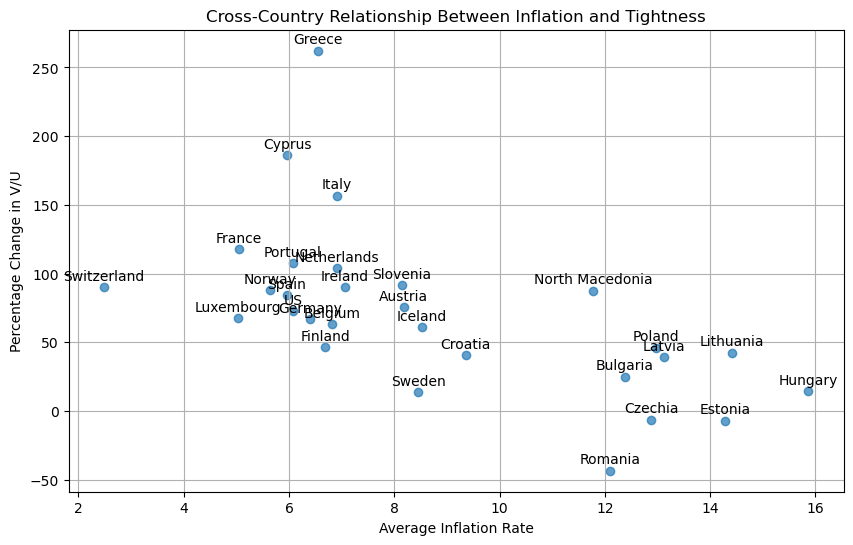

In [119]:
# 1. Calculate Average Inflation Rate for 2021-2023
inflation_2021_2023 = final[(final['year'] >= 2022) & (final['year'] <= 2023)].groupby('country')['P_12m_change'].mean().reset_index()
inflation_2021_2023.columns = ['country', 'avg_inflation_2021_2023']

# 2. Calculate Pre-Pandemic Average Vacancy-to-Unemployment Rate (2016-2019)
vacancy_pre_pandemic = final[(final['year'] >= 2016) & (final['year'] <= 2019)].groupby('country')['tightness'].mean().reset_index()
vacancy_pre_pandemic.columns = ['country', 'avg_vacancy_pre_pandemic']

# Calculate average tightness for 2021-2023
vacancy_inflation = final[(final['year'] >= 2022) & (final['year'] <= 2023)].groupby('country')['tightness'].mean().reset_index()
vacancy_inflation.columns = ['country', 'avg_vacancy_inflation']

# Merge data
merged_data = inflation_2021_2023.merge(vacancy_pre_pandemic, on='country').merge(vacancy_inflation, on='country')

# Calculate percentage change
merged_data['vacancy_change'] = (merged_data['avg_vacancy_inflation'] - merged_data['avg_vacancy_pre_pandemic']) / merged_data['avg_vacancy_pre_pandemic'] * 100

# 3. Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['avg_inflation_2021_2023'], merged_data['vacancy_change'], alpha=0.7)

# Annotate each point with the country name
for i, row in merged_data.iterrows():
    plt.annotate(row['country'], (row['avg_inflation_2021_2023'], row['vacancy_change']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Cross-Country Relationship Between Inflation and Tightness')
plt.xlabel('Average Inflation Rate')
plt.ylabel('Percentage Change in V/U')
plt.grid()

# Save the plot as a PNG file
plt.savefig(f"{output_dir}/inflation_vs_vacancy_change.png", format='png', dpi=300)
plt.show()


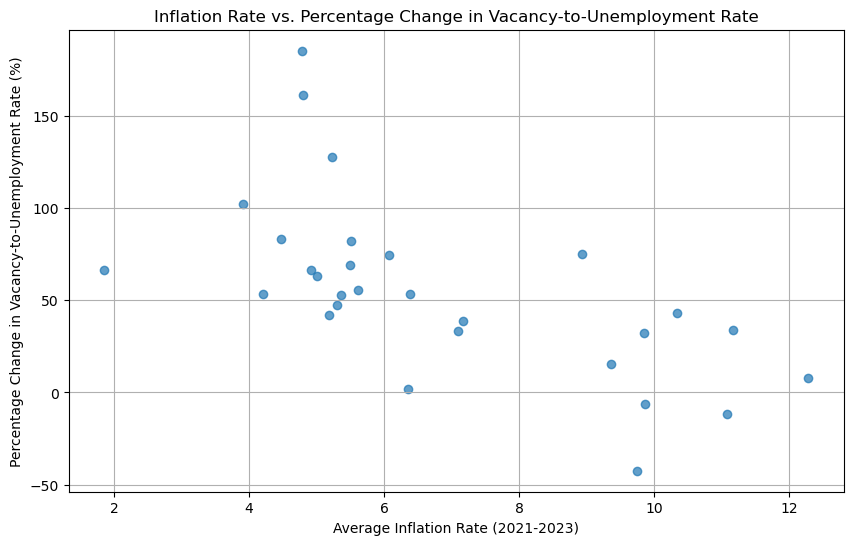

In [113]:
# 1. Calculate Average Inflation Rate for 2021-2023
# Note: You'll need to ensure you have the inflation data for 2021-2023 included in your DataFrame.
inflation_2021_2023 = final[(final['year'] >= 2021) & (final['year'] <= 2023)].groupby('country')['P_12m_change'].mean().reset_index()
inflation_2021_2023.columns = ['country', 'avg_inflation_2021_2023']

# 2. Calculate Pre-Pandemic Average Vacancy-to-Unemployment Rate (2016-2019)
vacancy_pre_pandemic = final[(final['year'] >= 2016) & (final['year'] <= 2019)].groupby('country')['tightness'].mean().reset_index()
vacancy_pre_pandemic.columns = ['country', 'avg_vacancy_pre_pandemic']

# Assuming you have the average tightness for 2021-2023 in a similar DataFrame, calculate percentage change
# Here, for demonstration purposes, let's assume 'avg_tightness_inflation' is available.
# For the example, we will use the same average value.
vacancy_inflation = final[(final['year'] >= 2021) & (final['year'] <= 2023)].groupby('country')['tightness'].mean().reset_index()
vacancy_inflation.columns = ['country', 'avg_vacancy_inflation']

# Merge data
merged_data = inflation_2021_2023.merge(vacancy_pre_pandemic, on='country').merge(vacancy_inflation, on='country')

# Calculate percentage change
merged_data['vacancy_change'] = (merged_data['avg_vacancy_inflation'] - merged_data['avg_vacancy_pre_pandemic']) / merged_data['avg_vacancy_pre_pandemic'] * 100

# 3. Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['avg_inflation_2021_2023'], merged_data['vacancy_change'], alpha=0.7)
plt.title()
plt.xlabel('Average Inflation Rate (2021-2023)')
plt.ylabel('Percentage Change in V/U')
plt.grid()
plt.show()